# Baseline Models

Train and evaluate traditional machine learning models for emotion classification.


## Import Libraries


In [7]:
import pandas as pd
import numpy as np
import json
import warnings
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix
)
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline
import matplotlib.pyplot as plt
import seaborn as sns
import os

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
os.makedirs('../results/models', exist_ok=True)
os.makedirs('../results/figures', exist_ok=True)


## Load Data


In [8]:
train_df = pd.read_csv('../data/processed/train_processed.csv')
val_df = pd.read_csv('../data/processed/val_processed.csv')
test_df = pd.read_csv('../data/processed/test_processed.csv')

print(f"Train: {train_df.shape} | Val: {val_df.shape} | Test: {test_df.shape}")


Train: (43362, 2) | Val: (5422, 2) | Test: (5423, 2)


## Load Label Encoder


In [9]:
with open('../data/processed/emotion_mapping.json', 'r') as f:
    emotion_mapping = json.load(f)

label_encoder = LabelEncoder()
label_encoder.fit(train_df['emotion'])

print("Emotion to ID mapping:")
for emotion, idx in emotion_mapping['emotion_to_id'].items():
    print(f"  {emotion}: {idx}")


Emotion to ID mapping:
  anger: 0
  disgust: 1
  fear: 2
  joy: 3
  neutral: 4
  sadness: 5
  surprise: 6


## Prepare Data


In [10]:
X_train = train_df['text'].values
y_train = label_encoder.transform(train_df['emotion'])

X_val = val_df['text'].values
y_val = label_encoder.transform(val_df['emotion'])

X_test = test_df['text'].values
y_test = label_encoder.transform(test_df['emotion'])

print(f"Train: {len(X_train)} samples")
print(f"Val: {len(X_val)} samples")
print(f"Test: {len(X_test)} samples")


Train: 43362 samples
Val: 5422 samples
Test: 5423 samples


## Feature Extraction


In [11]:
tfidf_vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 2), min_df=2)

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_val_tfidf = tfidf_vectorizer.transform(X_val)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print(f"TF-IDF features: {X_train_tfidf.shape[1]}")
print(f"Train shape: {X_train_tfidf.shape}")
print(f"Val shape: {X_val_tfidf.shape}")
print(f"Test shape: {X_test_tfidf.shape}")


TF-IDF features: 10000
Train shape: (43362, 10000)
Val shape: (5422, 10000)
Test shape: (5423, 10000)


## Balance Classes to Mean


In [12]:
print("Original class distribution:")
emotion_counts = pd.Series(y_train).value_counts().sort_index()
for emotion, idx in emotion_mapping['emotion_to_id'].items():
    count = emotion_counts[idx]
    print(f"  {emotion:10s}: {count:6,} samples")

mean_samples = int(emotion_counts.mean())
print(f"\nMean samples per class: {mean_samples:,}")
print(f"Imbalance ratio: {emotion_counts.max() / emotion_counts.min():.2f}:1")

print("\nBalancing classes to mean...")
print("  - Oversampling classes below mean")
print("  - Undersampling classes above mean")

oversample_strategy = {cls: mean_samples for cls in emotion_counts.index if emotion_counts[cls] < mean_samples}
undersample_strategy = {cls: mean_samples for cls in emotion_counts.index if emotion_counts[cls] > mean_samples}

print(f"\nOversampling {len(oversample_strategy)} classes")
print(f"Undersampling {len(undersample_strategy)} classes")

steps = []
if oversample_strategy:
    smote = SMOTE(sampling_strategy=oversample_strategy, random_state=42, k_neighbors=3)
    steps.append(('oversample', smote))
if undersample_strategy:
    rus = RandomUnderSampler(sampling_strategy=undersample_strategy, random_state=42)
    steps.append(('undersample', rus))

if steps:
    pipeline = ImbPipeline(steps)
    X_train_balanced, y_train_balanced = pipeline.fit_resample(X_train_tfidf, y_train)
else:
    X_train_balanced, y_train_balanced = X_train_tfidf, y_train

print(f"\nAfter balancing:")
print(f"  Original size: {len(y_train):,} samples")
print(f"  Balanced size: {len(y_train_balanced):,} samples")

balanced_counts = pd.Series(y_train_balanced).value_counts().sort_index()
print("\nBalanced class distribution (all at mean):")
for emotion, idx in emotion_mapping['emotion_to_id'].items():
    count = balanced_counts[idx]
    print(f"  {emotion:10s}: {count:6,} samples")


Original class distribution:
  anger     :  5,335 samples
  disgust   :    579 samples
  fear      :    615 samples
  joy       :  9,075 samples
  neutral   : 23,238 samples
  sadness   :  2,371 samples
  surprise  :  2,149 samples

Mean samples per class: 6,194
Imbalance ratio: 40.13:1

Balancing classes to mean...
  - Oversampling classes below mean
  - Undersampling classes above mean

Oversampling 5 classes
Undersampling 2 classes

After balancing:
  Original size: 43,362 samples
  Balanced size: 43,358 samples

Balanced class distribution (all at mean):
  anger     :  6,194 samples
  disgust   :  6,194 samples
  fear      :  6,194 samples
  joy       :  6,194 samples
  neutral   :  6,194 samples
  sadness   :  6,194 samples
  surprise  :  6,194 samples


## Train Baseline Model


In [13]:
baseline_model = LogisticRegression(max_iter=1000, random_state=42)

print("Training Logistic Regression baseline model on balanced data...")
baseline_model.fit(X_train_balanced, y_train_balanced)
print("Model trained")


Training Logistic Regression baseline model on balanced data...
Model trained


## Evaluate Baseline Model


In [14]:
y_pred = baseline_model.predict(X_test_tfidf)

baseline_results = {
    'accuracy': accuracy_score(y_test, y_pred),
    'precision': precision_score(y_test, y_pred, average='weighted'),
    'recall': recall_score(y_test, y_pred, average='weighted'),
    'f1': f1_score(y_test, y_pred, average='weighted')
}

results_df = pd.DataFrame([baseline_results], index=['Logistic Regression'])
results_df = results_df.round(4)

print("Baseline Model Performance on Test Set:")
print(results_df)


Baseline Model Performance on Test Set:
                     accuracy  precision  recall      f1
Logistic Regression    0.5366     0.6179  0.5366  0.5556


## Visualize Results


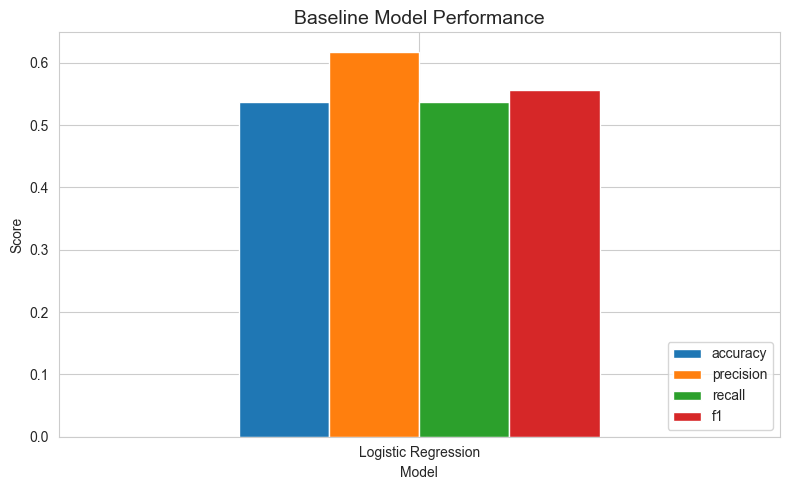

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

results_df.plot(kind='bar', y=['accuracy', 'precision', 'recall', 'f1'], ax=ax)
ax.set_title('Baseline Model Performance', fontsize=14)
ax.set_xlabel('Model')
ax.set_ylabel('Score')
ax.legend(loc='lower right')
ax.tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.savefig('../results/figures/baseline_model_performance.png', dpi=300, bbox_inches='tight')
plt.show()


## Classification Report


In [16]:
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))


Classification Report:
              precision    recall  f1-score   support

       anger       0.38      0.56      0.45       703
     disgust       0.29      0.52      0.37        84
        fear       0.36      0.62      0.46        90
         joy       0.63      0.64      0.63      1109
     neutral       0.76      0.49      0.60      2866
     sadness       0.34      0.52      0.42       287
    surprise       0.22      0.50      0.30       284

    accuracy                           0.54      5423
   macro avg       0.43      0.55      0.46      5423
weighted avg       0.62      0.54      0.56      5423



## Confusion Matrix


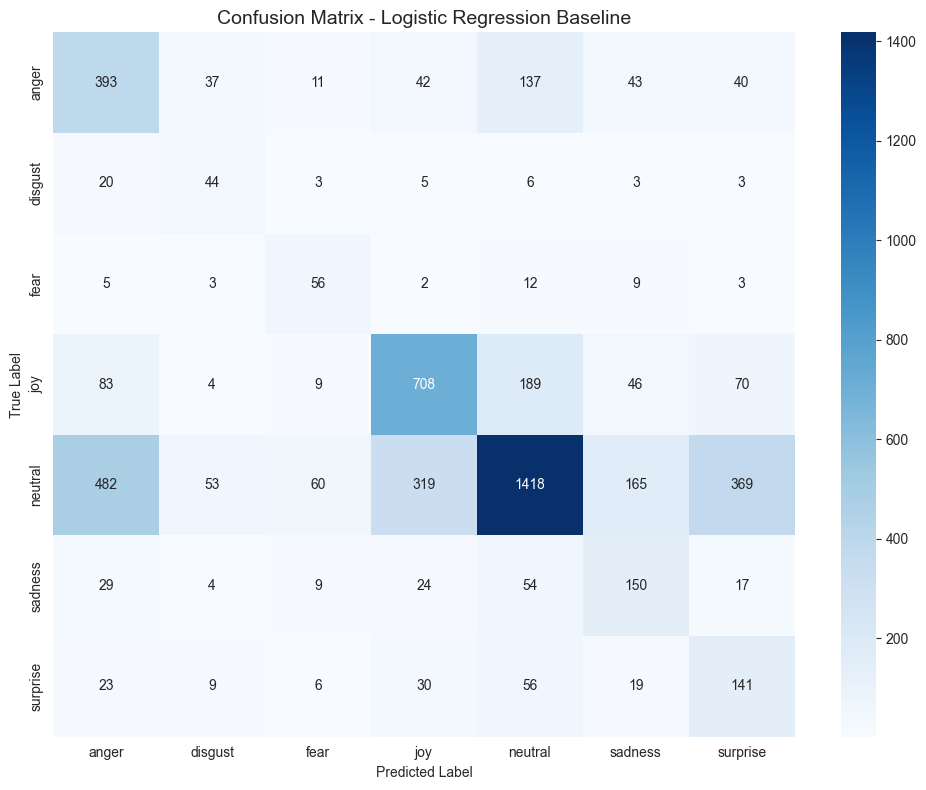

In [17]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix - Logistic Regression Baseline', fontsize=14)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('../results/figures/confusion_matrix_baseline.png', dpi=300, bbox_inches='tight')
plt.show()


## Save Results


In [18]:
results_df.to_csv('../results/models/baseline_model_results.csv')

print("Results saved to: ../results/models/baseline_model_results.csv")
print(f"\nBaseline Model: Logistic Regression")
print(f"F1-score: {baseline_results['f1']:.4f}")
print(f"Accuracy: {baseline_results['accuracy']:.4f}")


Results saved to: ../results/models/baseline_model_results.csv

Baseline Model: Logistic Regression
F1-score: 0.5556
Accuracy: 0.5366
